In [1]:
!which python

/Users/pushkalm11/miniconda3/envs/unrolling/bin/python


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.linalg import matrix_power as MP

In [3]:
from scipy.spatial.distance import cdist
from scipy.io import savemat, loadmat

In [4]:
import networkx as nx
import sys

In [5]:
import tensorflow as tf
from tensorflow.math import scalar_mul as c_mul
from keras.callbacks import EarlyStopping

In [6]:
print(f"TF Version: {tf.__version__}")

TF Version: 2.14.0


In [7]:
X_train = loadmat('./Dataset/X_train.mat')['X']

N, T = X_train.shape

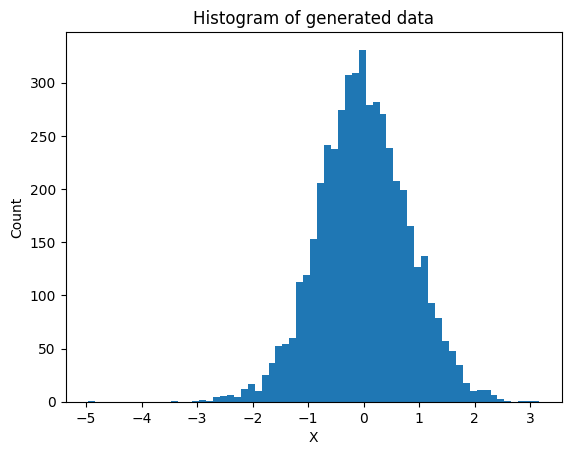

In [8]:
plt.hist(np.array(X_train).flatten(), bins = 'auto')
plt.xlabel("X")
plt.ylabel("Count")
plt.title("Histogram of generated data")
plt.show()

In [9]:
print(N, T)

32 152


In [10]:
dt = np.zeros([T - 1, T])

for i in range(T - 1):
    dt[i, i] = -1
    dt[i, i - 1] = 1

d = dt.T
d = np.concatenate((d, np.zeros([T, 1])), axis = 1) 
d[T - 1, T - 1] = -1
d = d.T
d[T - 1, T - 1] = 1 
d[-1, -2] = 1
d[0, -1] = 0

d = tf.convert_to_tensor(d, dtype = "float32")

print(d)

tf.Tensor(
[[-1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1.  1.]], shape=(152, 152), dtype=float32)


In [11]:
Mul = np.eye(N) - np.ones([N, N])
Mul = tf.convert_to_tensor(Mul, dtype = "float32")

In [12]:
def adj_to_laplacian(AdjL):
    tmp = np.array(AdjL, dtype = "float32")
    return np.diag(np.sum(tmp, axis = 0)) - tmp

In [13]:
def initial_graph(X_training, N, top_values = 6):
    distance_matrix = cdist(X_training, X_training, metric = 'euclidean')
    
    # top_values = 6
    sorted_indices = distance_matrix.argsort(1)
    TAdj = np.zeros([N, N])
    
    for i in range(N):
        for j in range(1, top_values):
            k = sorted_indices[i][j]
            TAdj[i][k] = 1
    
    TAdj = (TAdj + TAdj.T) / 2
    TAdj = np.where(TAdj > 0.1, 1, 0)
    
    Laplacian_init = np.diag(np.sum(TAdj, 1)) - TAdj
    
    return Laplacian_init

In [14]:
coeffs = 0
psi_cost = 0
Laplacian = 0
A_transform_cost = 0

model_pred = []
loss_model = []
learned_graph = []
mse_known_list = []
mse_unknown_list = []

In [15]:
coeffs_list = np.load("./Outputs/cost_func_coeffs.npy")
print(coeffs_list.shape)

(50, 4)


In [16]:
# A - Target, B - Predicted
def costfunc(A, B):
    global coeffs
    global X_train
    global psi_cost
    global Laplacian
    global A_transform_cost

    B_tmp = tf.squeeze(B)
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2) * coeffs[0]
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost) * coeffs[1]
    L_cost = (tf.norm(Laplacian) ** 2) * coeffs[2]
    Z_cost = (tf.norm(A_transform_cost) ** 2) * coeffs[3]
    
    tmp = (smoothness) + (data_fidelity) + (L_cost) + (Z_cost)
    
    global loss_model
    loss_model.append(tmp)
    
    return tmp
    
def costfunc1(A, B):
    global X_train
    global psi_cost
    
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2)
    return (data_fidelity)

def costfunc2(A, B):
    global Laplacian
    global A_transform_cost
    
    B_tmp = tf.squeeze(B)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    
    return (smoothness)

def costfunc3(A, B):
    global Laplacian
    
    L_cost = (tf.norm(Laplacian) ** 2)
    
    return (L_cost)

def costfunc4(A, B):
    global A_transform_cost
    
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (Z_cost)

In [17]:
def mse_unknown(A, B):
    
    global psi_cost
    psi = psi_cost
    
    psid = tf.convert_to_tensor(np.ones([N, T], dtype = float) - psi, dtype = "float32")
    mse_unk = (LA.norm(np.multiply(psid, (X_train - B))) ** 2) / np.sum(psid.numpy().flatten())
    
    global mse_unknown_list
    mse_unknown_list.append(mse_unk)
    
    return mse_unk

def mse_known(A, B):
    
    global psi_cost
    psi = psi_cost
    
    mse_kn = (LA.norm(np.multiply(psi, (X_train - B))) ** 2) / np.sum(psi.numpy().flatten())
    
    global model_pred
    model_pred.append([A.numpy(), B.numpy()])
    
    global mse_known_list
    mse_known_list.append(mse_kn)
    
    return mse_kn

In [18]:
callb = EarlyStopping(monitor = 'loss', mode = 'min', min_delta = 0.0001, verbose = 1, patience = 10)
lr_decay_factor = 1
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr / lr_decay_factor

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [19]:
class ProposedModel(tf.keras.Model):
    
    def __init__(self, L_init, reg_init, loops_init, d_init, p_init, alpha_init, beta_init, threshold_in, **kwargs):
        super(ProposedModel, self).__init__(**kwargs)
        
        self.p1_init = tf.constant(p_init[0], shape = (1, 1), dtype = "float32")
        self.p1 = tf.Variable(initial_value = self.p1_init, trainable = True, name = "p1")
        
        self.p2_init = tf.constant(p_init[1], shape = (1, 1), dtype = "float32")
        self.p2 = tf.Variable(initial_value = self.p2_init, trainable = True, name = "p2")
        
        self.L_in = L_init
        self.preg = reg_init
        self.loops = loops_init
        self.d_int = d_init
        self.alp = alpha_init
        self.bet = beta_init
        self.threshold_init = threshold_in
        
    def data_inpainting(self, psi, Y, Lk, AAT):
        loop_b, reg = self.loops[1], self.preg

        Xk = tf.zeros_like(Y)
        Zk = -(tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT)))
        
        for i in range(loop_b):
            fdx_xk = tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT))

            # row_print = 4
            # tmp = list(zip((tf.multiply(psi, Xk) - Y)[:, row_print].numpy(), (2 * reg * (Lk @ Xk @ AAT)[:, row_print].numpy())))
            # print("\n\nStart here")
            # for k in tmp:
            #     print(k)
            
            fdx_zk = tf.multiply(psi, Zk) - Y + (2 * reg * (Lk @ Zk @ AAT))
            
            tau = tf.linalg.trace(tf.transpose(fdx_xk) @ Zk) / tf.linalg.trace(tf.transpose((Y + fdx_zk)) @ Zk)
            
            Xk_1 = Xk - (tau * Zk)

            fdx_xk_1 = tf.multiply(psi, Xk_1) - Y + (2 * reg * (Lk @ Xk_1 @ AAT))
            gamma = (tf.norm(fdx_xk_1) ** 2) / (tf.norm(fdx_xk) ** 2)

            Zk_1 = (gamma * Zk) - fdx_xk_1

            Xk = Xk_1
            Zk = Zk_1
        # print("\n\nEnds here\n\n")
        return Xk_1 
    
    def graph_learning(self, X, Lk, AAT):
        loop_c, alpha, beta = self.loops[2], self.alp, self.bet
        
        # Computing the smoothness term
        X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
        
        for i in range(loop_c):

            # Extracting the adjacency matrix from the Laplacian
            adj_i = tf.multiply(Mul, Lk)

            # Computing the gradient with respect to laplacian
            fdL_Lk = X_AAT_XT + (beta * Lk)
            
            # row_print = 4
            # print("For beta")
            # tmp = list(zip(X_AAT_XT[row_print, :].numpy(), np.array(beta * Lk)[row_print, :]))
            # for k in tmp:
            #     print(k)
            
            # Extracting the adjacency matrix from the gradient
            adj_grad = tf.multiply(Mul, fdL_Lk)
            
            # Computing the new adjacency
            # tmp = list(zip(adj_i[row_print, :].numpy(), (alpha * adj_grad)[row_print, :].numpy()))
            # if i == (loop_c-1):
            #     print("\nFor alpha")
            #     for k in tmp:
            #         print(k)
            #     print("\nStart here")
            
            adj_i1 = adj_i - (alpha * adj_grad)
            
            # Avoiding any negative values
            adj_i1 = tf.nn.relu(adj_i1)

            # Computing the new laplacian
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(adj_i1, 1)) - adj_i1
            
            # Updating the laplacian
            Lk = Lk_1
        # print("\n\nEnds here\n\n")
        return Lk
    

    def call(self, y):

        psi = y[0,:,T:]
        global psi_cost
        psi_cost = psi

        psi = tf.convert_to_tensor(psi, dtype = "float32")
        
        X_in = y[0,:,:T]
        X_in = psi * tf.convert_to_tensor(X_in, dtype = "float32")
        Y = X_in
        
        d = self.d_int
        LT = tf.matmul(d, tf.transpose(d))
        LT = tf.convert_to_tensor(LT, dtype = "float32")
        
        A_transform = tf.eye(T) + (self.p1 * MP(LT, 1)) + (self.p2 * MP(LT, 2))
        AAT = A_transform
        
        global A_transform_cost
        A_transform_cost = AAT
        
        loop_a = self.loops[0]
        threshold = self.threshold_init
        Lk = self.L_in
        
        for i in range(loop_a):
            
            Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
            
            Xk_1_gt = X_in + tf.multiply((tf.ones(psi.shape) - psi), Xk_1)
            
            Lk_1 = self.graph_learning(Xk_1_gt, Lk, AAT)
            
            Adj = tf.linalg.diag(tf.linalg.diag_part(Lk_1)) - Lk_1 # Gives adjacency
            
            n = tf.math.count_nonzero(Adj, dtype="float32")
            mean = tf.math.reduce_sum(Adj) / n
            Adj = tf.math.subtract(Adj, (threshold * mean)) # Ensures the sparsity of learned graph
            
            Adj = tf.nn.relu(Adj)
            # Adj = tf.math.sign(Adj)
            
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj, 1)) - Adj
            
            Lk = Lk_1
        
            global Laplacian
            Laplacian = Lk
        
        Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
        
        global learned_graph
        learned_graph.append(Lk.numpy())
        
        return tf.reshape(Xk_1, [1, N, T])

In [20]:
Lap_init = initial_graph(X_train, N, 6)

loop_a = 5
loop_b = 20 # Data Inpainting
loop_c = 10 # Graph Learning

reg_init = 2.0e-7

alpha_init = 1.0e-4
beta_init = 1.0e1

threshold_init = 0.2

no_of_psi = 20
# sensing_ratio = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]
sensing_ratio = list(np.arange(1, 51, 1)/ 100.0)

p_init = [30.0, 60.0]
lr_decay_factor = 1.2

all_psi = []
all_vars = []

In [21]:
for i_sen, rem in enumerate(sensing_ratio):
    
    print(f"\n\n###########################################################################################")
    print(f"################################### Sensing Ratio: {rem * 100}% ###################################")
    print(f"###########################################################################################\n\n")
    
    if i_sen == 0:
        M = int(rem * T)
        X_train_missing = np.zeros([no_of_psi, N, T])
        X_train_concatenated = np.zeros([no_of_psi, N, 2*T])
    
        for i in range(no_of_psi):
            psi_k = np.array([0] * (N * M) + [1] * (N * (T - M)))
            np.random.shuffle(psi_k)
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)

    else:
        previous_psi = all_psi[-no_of_psi : ]
        X_train_missing = np.zeros([no_of_psi, N, T])
        X_train_concatenated = np.zeros([no_of_psi, N, 2 * T])
        
        rem_diff = int(N * (rem - sensing_ratio[i_sen - 1]) * T)
        
        for i in range(no_of_psi):
            psi_k_tmp = np.array(previous_psi[i]).flatten()
            ones_idx = np.where(psi_k_tmp == 1)
            
            ones_to_zero_idx = np.random.choice(ones_idx[0], size = rem_diff)
            psi_k_tmp[ones_to_zero_idx] = 0
            psi_k = psi_k_tmp
            
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)
    
    coeffs = coeffs_list[i_sen, : ]
    
    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0005, momentum = 0.0)
    
    our_model = ProposedModel(Lap_init, reg_init, [loop_a, loop_b, loop_c], 
                              d, p_init, alpha_init, beta_init, threshold_init, name = 'our')
    our_model.compile(optimizer = sgd_optimizer, loss = costfunc,
                      metrics = [mse_known, mse_unknown], run_eagerly=True)
    
    our_model.fit(X_train_concatenated, X_train_missing, epochs = 15, 
                  callbacks = [lr_scheduler], batch_size = 1)
    
    var = our_model.variables
    var_lst = []
    for v in var:
        var_lst.append(v.numpy()[0, 0])
    print(f"\nFilter Coefficients:", var_lst)
    all_vars.append(var_lst)



###########################################################################################
################################### Sensing Ratio: 1.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 627ms/step - loss: 10551.4043 - mse_known: 6.1777e-04 - mse_unknown: 0.1519 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 645ms/step - loss: 9773.5439 - mse_known: 5.3371e-04 - mse_unknown: 0.1520 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 646ms/step - loss: 9035.7100 - mse_known: 4.5912e-04 - mse_unknown: 0.1522 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 652ms/step - loss: 8391.0117 - mse_known: 3.9799e-04 - mse_unknown: 0.1523 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 640ms/step - loss: 7879.4438 - mse_known: 3.5237e-04 - mse_unknown: 0.1


Filter Coefficients: [23.14178, 42.047333]


###########################################################################################
################################### Sensing Ratio: 2.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 632ms/step - loss: 10512.3760 - mse_known: 6.1706e-04 - mse_unknown: 0.1585 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 629ms/step - loss: 9738.8154 - mse_known: 5.3331e-04 - mse_unknown: 0.1588 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 628ms/step - loss: 9005.4502 - mse_known: 4.5893e-04 - mse_unknown: 0.1589 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 631ms/step - loss: 8364.4746 - mse_known: 3.9791e-04 - mse_unknown: 0.1590 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 631ms/step - loss: 7855.942


Filter Coefficients: [23.169712, 42.09703]


###########################################################################################
################################### Sensing Ratio: 3.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 628ms/step - loss: 10436.1309 - mse_known: 6.0868e-04 - mse_unknown: 0.1730 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 630ms/step - loss: 9671.1777 - mse_known: 5.2647e-04 - mse_unknown: 0.1732 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 636ms/step - loss: 8945.8848 - mse_known: 4.5345e-04 - mse_unknown: 0.1733 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 634ms/step - loss: 8312.3418 - mse_known: 3.9353e-04 - mse_unknown: 0.1735 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 633ms/step - loss: 7809.524


Filter Coefficients: [23.214945, 42.194214]


###########################################################################################
################################### Sensing Ratio: 4.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 638ms/step - loss: 10388.9365 - mse_known: 6.0769e-04 - mse_unknown: 0.1777 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 634ms/step - loss: 9629.9658 - mse_known: 5.2605e-04 - mse_unknown: 0.1780 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 650ms/step - loss: 8910.2598 - mse_known: 4.5338e-04 - mse_unknown: 0.1782 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 641ms/step - loss: 8281.4473 - mse_known: 3.9375e-04 - mse_unknown: 0.1783 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 648ms/step - loss: 7782.38


Filter Coefficients: [23.247509, 42.257427]


###########################################################################################
################################### Sensing Ratio: 5.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 665ms/step - loss: 10336.7090 - mse_known: 6.0479e-04 - mse_unknown: 0.1777 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 651ms/step - loss: 9583.9023 - mse_known: 5.2344e-04 - mse_unknown: 0.1779 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 649ms/step - loss: 8870.0264 - mse_known: 4.5200e-04 - mse_unknown: 0.1781 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 651ms/step - loss: 8246.2891 - mse_known: 3.9274e-04 - mse_unknown: 0.1783 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 651ms/step - loss: 7751.29


Filter Coefficients: [23.280188, 42.326702]


###########################################################################################
################################### Sensing Ratio: 6.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 12s 623ms/step - loss: 10257.2344 - mse_known: 5.9697e-04 - mse_unknown: 0.1767 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 12s 622ms/step - loss: 9513.4473 - mse_known: 5.1688e-04 - mse_unknown: 0.1769 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 12s 624ms/step - loss: 8808.1738 - mse_known: 4.4671e-04 - mse_unknown: 0.1770 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 625ms/step - loss: 8191.9897 - mse_known: 3.8819e-04 - mse_unknown: 0.1772 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 12s 624ms/step - loss: 7702.87


Filter Coefficients: [23.32736, 42.430664]


###########################################################################################
################################### Sensing Ratio: 7.000000000000001% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 12s 623ms/step - loss: 10206.9385 - mse_known: 5.9370e-04 - mse_unknown: 0.1784 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 12s 620ms/step - loss: 9468.9141 - mse_known: 5.1468e-04 - mse_unknown: 0.1787 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 12s 623ms/step - loss: 8769.1621 - mse_known: 4.4427e-04 - mse_unknown: 0.1789 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 12s 625ms/step - loss: 8157.6680 - mse_known: 3.8690e-04 - mse_unknown: 0.1790 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 629ms/step - 


Filter Coefficients: [23.358389, 42.495373]


###########################################################################################
################################### Sensing Ratio: 8.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 12s 625ms/step - loss: 10154.1367 - mse_known: 5.9121e-04 - mse_unknown: 0.1784 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 12s 624ms/step - loss: 9422.2393 - mse_known: 5.1256e-04 - mse_unknown: 0.1786 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 12s 625ms/step - loss: 8728.2939 - mse_known: 4.4327e-04 - mse_unknown: 0.1788 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 661ms/step - loss: 8121.9805 - mse_known: 3.8658e-04 - mse_unknown: 0.1789 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 664ms/step - loss: 7640.82


Filter Coefficients: [23.393734, 42.564865]


###########################################################################################
################################### Sensing Ratio: 9.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 659ms/step - loss: 10111.4473 - mse_known: 5.9075e-04 - mse_unknown: 0.1786 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 664ms/step - loss: 9384.7305 - mse_known: 5.1294e-04 - mse_unknown: 0.1788 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 659ms/step - loss: 8695.6660 - mse_known: 4.4352e-04 - mse_unknown: 0.1790 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 657ms/step - loss: 8093.5947 - mse_known: 3.8637e-04 - mse_unknown: 0.1792 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 662ms/step - loss: 7615.70


Filter Coefficients: [23.422234, 42.622894]


###########################################################################################
################################### Sensing Ratio: 10.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 656ms/step - loss: 10055.7773 - mse_known: 5.8603e-04 - mse_unknown: 0.1821 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 654ms/step - loss: 9335.1914 - mse_known: 5.0917e-04 - mse_unknown: 0.1823 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 663ms/step - loss: 8651.9580 - mse_known: 4.4015e-04 - mse_unknown: 0.1826 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 663ms/step - loss: 8054.9478 - mse_known: 3.8358e-04 - mse_unknown: 0.1827 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 663ms/step - loss: 7581.1


Filter Coefficients: [23.45856, 42.69293]


###########################################################################################
################################### Sensing Ratio: 11.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 662ms/step - loss: 9934.6465 - mse_known: 5.6727e-04 - mse_unknown: 0.1883 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 658ms/step - loss: 9226.7539 - mse_known: 4.9257e-04 - mse_unknown: 0.1885 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 661ms/step - loss: 8555.6982 - mse_known: 4.2586e-04 - mse_unknown: 0.1888 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 658ms/step - loss: 7969.5303 - mse_known: 3.7242e-04 - mse_unknown: 0.1889 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 660ms/step - loss: 7504.3838


Filter Coefficients: [23.524273, 42.847393]


###########################################################################################
################################### Sensing Ratio: 12.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 659ms/step - loss: 9858.5781 - mse_known: 5.5845e-04 - mse_unknown: 0.1905 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 662ms/step - loss: 9158.9043 - mse_known: 4.8450e-04 - mse_unknown: 0.1907 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 665ms/step - loss: 8495.7588 - mse_known: 4.2055e-04 - mse_unknown: 0.1909 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 661ms/step - loss: 7916.5181 - mse_known: 3.6643e-04 - mse_unknown: 0.1911 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 662ms/step - loss: 7456.84


Filter Coefficients: [23.563614, 42.94765]


###########################################################################################
################################### Sensing Ratio: 13.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 656ms/step - loss: 9796.2676 - mse_known: 5.5215e-04 - mse_unknown: 0.1915 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 658ms/step - loss: 9103.4385 - mse_known: 4.8011e-04 - mse_unknown: 0.1917 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 664ms/step - loss: 8446.8340 - mse_known: 4.1630e-04 - mse_unknown: 0.1919 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 660ms/step - loss: 7873.3047 - mse_known: 3.6409e-04 - mse_unknown: 0.1920 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 663ms/step - loss: 7418.191


Filter Coefficients: [23.602541, 43.028763]


###########################################################################################
################################### Sensing Ratio: 14.000000000000002% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 662ms/step - loss: 9659.5352 - mse_known: 5.2898e-04 - mse_unknown: 0.1930 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 660ms/step - loss: 8980.9346 - mse_known: 4.6118e-04 - mse_unknown: 0.1932 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 660ms/step - loss: 8338.1162 - mse_known: 4.0115e-04 - mse_unknown: 0.1934 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 662ms/step - loss: 7776.7695 - mse_known: 3.5084e-04 - mse_unknown: 0.1935 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 662ms/step -


Filter Coefficients: [23.676348, 43.205563]


###########################################################################################
################################### Sensing Ratio: 15.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 663ms/step - loss: 9579.2012 - mse_known: 5.2045e-04 - mse_unknown: 0.1940 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 659ms/step - loss: 8909.4053 - mse_known: 4.5390e-04 - mse_unknown: 0.1942 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 662ms/step - loss: 8275.0010 - mse_known: 3.9461e-04 - mse_unknown: 0.1944 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 659ms/step - loss: 7720.9600 - mse_known: 3.4481e-04 - mse_unknown: 0.1945 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 655ms/step - loss: 7281.34


Filter Coefficients: [23.719042, 43.314526]


###########################################################################################
################################### Sensing Ratio: 16.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 660ms/step - loss: 9517.8701 - mse_known: 5.1410e-04 - mse_unknown: 0.1956 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 657ms/step - loss: 8854.7363 - mse_known: 4.4865e-04 - mse_unknown: 0.1958 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 657ms/step - loss: 8226.7578 - mse_known: 3.9173e-04 - mse_unknown: 0.1960 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 664ms/step - loss: 7678.3228 - mse_known: 3.4182e-04 - mse_unknown: 0.1961 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 665ms/step - loss: 7243.14


Filter Coefficients: [23.756327, 43.395737]


###########################################################################################
################################### Sensing Ratio: 17.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 657ms/step - loss: 9442.4746 - mse_known: 5.0777e-04 - mse_unknown: 0.1973 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 659ms/step - loss: 8787.6357 - mse_known: 4.4184e-04 - mse_unknown: 0.1975 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 658ms/step - loss: 8167.3193 - mse_known: 3.8497e-04 - mse_unknown: 0.1977 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 659ms/step - loss: 7625.6772 - mse_known: 3.3735e-04 - mse_unknown: 0.1978 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 659ms/step - loss: 7195.90


Filter Coefficients: [23.796734, 43.4979]


###########################################################################################
################################### Sensing Ratio: 18.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 658ms/step - loss: 9380.6250 - mse_known: 5.0268e-04 - mse_unknown: 0.1983 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 660ms/step - loss: 8732.8701 - mse_known: 4.3987e-04 - mse_unknown: 0.1985 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 660ms/step - loss: 8119.3311 - mse_known: 3.8240e-04 - mse_unknown: 0.1987 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 657ms/step - loss: 7583.5322 - mse_known: 3.3571e-04 - mse_unknown: 0.1988 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 657ms/step - loss: 7158.3828


Filter Coefficients: [23.832918, 43.584843]


###########################################################################################
################################### Sensing Ratio: 19.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 658ms/step - loss: 9340.9629 - mse_known: 5.0096e-04 - mse_unknown: 0.1984 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 660ms/step - loss: 8697.6895 - mse_known: 4.3899e-04 - mse_unknown: 0.1986 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 659ms/step - loss: 8088.4790 - mse_known: 3.8257e-04 - mse_unknown: 0.1988 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 661ms/step - loss: 7556.4595 - mse_known: 3.3576e-04 - mse_unknown: 0.1989 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 661ms/step - loss: 7134.27


Filter Coefficients: [23.855652, 43.640633]


###########################################################################################
################################### Sensing Ratio: 20.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 664ms/step - loss: 9286.5215 - mse_known: 4.9917e-04 - mse_unknown: 0.2005 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 659ms/step - loss: 8649.5371 - mse_known: 4.3586e-04 - mse_unknown: 0.2007 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 662ms/step - loss: 8046.1343 - mse_known: 3.8028e-04 - mse_unknown: 0.2008 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 660ms/step - loss: 7519.1968 - mse_known: 3.3415e-04 - mse_unknown: 0.2010 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 660ms/step - loss: 7100.99


Filter Coefficients: [23.885113, 43.71778]


###########################################################################################
################################### Sensing Ratio: 21.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 662ms/step - loss: 9210.1426 - mse_known: 4.8969e-04 - mse_unknown: 0.2020 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 658ms/step - loss: 8581.3242 - mse_known: 4.2992e-04 - mse_unknown: 0.2022 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 657ms/step - loss: 7985.8467 - mse_known: 3.7544e-04 - mse_unknown: 0.2024 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 667ms/step - loss: 7465.8257 - mse_known: 3.3008e-04 - mse_unknown: 0.2025 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 651ms/step - loss: 7053.075


Filter Coefficients: [23.930746, 43.821083]


###########################################################################################
################################### Sensing Ratio: 22.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 12s 621ms/step - loss: 9138.0674 - mse_known: 4.8187e-04 - mse_unknown: 0.2042 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 12s 624ms/step - loss: 8516.8730 - mse_known: 4.2249e-04 - mse_unknown: 0.2043 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 12s 625ms/step - loss: 7928.5483 - mse_known: 3.6832e-04 - mse_unknown: 0.2045 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 12s 623ms/step - loss: 7414.8057 - mse_known: 3.2497e-04 - mse_unknown: 0.2046 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 640ms/step - loss: 7007.12


Filter Coefficients: [23.9678, 43.918964]


###########################################################################################
################################### Sensing Ratio: 23.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 654ms/step - loss: 9097.0547 - mse_known: 4.8302e-04 - mse_unknown: 0.2047 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 654ms/step - loss: 8481.0303 - mse_known: 4.2464e-04 - mse_unknown: 0.2049 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 651ms/step - loss: 7897.5781 - mse_known: 3.7066e-04 - mse_unknown: 0.2051 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 671ms/step - loss: 7388.0010 - mse_known: 3.2650e-04 - mse_unknown: 0.2052 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 672ms/step - loss: 6983.4971


Filter Coefficients: [23.996954, 43.980488]


###########################################################################################
################################### Sensing Ratio: 24.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 673ms/step - loss: 9012.1436 - mse_known: 4.7454e-04 - mse_unknown: 0.2055 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 660ms/step - loss: 8405.2051 - mse_known: 4.1580e-04 - mse_unknown: 0.2057 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 656ms/step - loss: 7830.4492 - mse_known: 3.6460e-04 - mse_unknown: 0.2059 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 654ms/step - loss: 7328.5117 - mse_known: 3.2164e-04 - mse_unknown: 0.2060 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 654ms/step - loss: 6930.07


Filter Coefficients: [24.049166, 44.09662]


###########################################################################################
################################### Sensing Ratio: 25.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 656ms/step - loss: 8917.7461 - mse_known: 4.5978e-04 - mse_unknown: 0.2076 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 658ms/step - loss: 8320.5645 - mse_known: 4.0492e-04 - mse_unknown: 0.2078 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 654ms/step - loss: 7755.0874 - mse_known: 3.5400e-04 - mse_unknown: 0.2080 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 657ms/step - loss: 7261.2710 - mse_known: 3.1351e-04 - mse_unknown: 0.2081 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 653ms/step - loss: 6869.264


Filter Coefficients: [24.097609, 44.224438]


###########################################################################################
################################### Sensing Ratio: 26.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 12s 622ms/step - loss: 8847.1758 - mse_known: 4.5197e-04 - mse_unknown: 0.2102 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 628ms/step - loss: 8257.3691 - mse_known: 3.9710e-04 - mse_unknown: 0.2104 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 12s 625ms/step - loss: 7698.8892 - mse_known: 3.4795e-04 - mse_unknown: 0.2106 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 12s 623ms/step - loss: 7211.1885 - mse_known: 3.0783e-04 - mse_unknown: 0.2107 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 12s 625ms/step - loss: 6824.10


Filter Coefficients: [24.13256, 44.323048]


###########################################################################################
################################### Sensing Ratio: 27.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 12s 621ms/step - loss: 8754.8906 - mse_known: 4.3829e-04 - mse_unknown: 0.2133 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 627ms/step - loss: 8174.5459 - mse_known: 3.8589e-04 - mse_unknown: 0.2135 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 626ms/step - loss: 7625.0288 - mse_known: 3.3730e-04 - mse_unknown: 0.2136 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 627ms/step - loss: 7145.1748 - mse_known: 2.9878e-04 - mse_unknown: 0.2138 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 12s 623ms/step - loss: 6764.304


Filter Coefficients: [24.180176, 44.44852]


###########################################################################################
################################### Sensing Ratio: 28.000000000000004% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 14s 688ms/step - loss: 8705.0684 - mse_known: 4.3676e-04 - mse_unknown: 0.2146 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 649ms/step - loss: 8130.4438 - mse_known: 3.8439e-04 - mse_unknown: 0.2147 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 649ms/step - loss: 7586.3687 - mse_known: 3.3751e-04 - mse_unknown: 0.2149 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 663ms/step - loss: 7111.2280 - mse_known: 2.9858e-04 - mse_unknown: 0.2150 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 647ms/step - 


Filter Coefficients: [24.210478, 44.522293]


###########################################################################################
################################### Sensing Ratio: 28.999999999999996% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 635ms/step - loss: 38605.2266 - mse_known: 3.4579e-04 - mse_unknown: 0.2196 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 636ms/step - loss: 28386.7930 - mse_known: 1.8527e-04 - mse_unknown: 0.2204 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 631ms/step - loss: 20098.7070 - mse_known: 9.0692e-05 - mse_unknown: 0.2207 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 634ms/step - loss: 14178.3252 - mse_known: 4.4768e-05 - mse_unknown: 0.2205 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 634ms/st


Filter Coefficients: [7.509207, 12.166766]


###########################################################################################
################################### Sensing Ratio: 30.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 634ms/step - loss: 8511.6553 - mse_known: 4.1071e-04 - mse_unknown: 0.2206 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 638ms/step - loss: 7956.9077 - mse_known: 3.6078e-04 - mse_unknown: 0.2208 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 639ms/step - loss: 7431.6733 - mse_known: 3.1792e-04 - mse_unknown: 0.2209 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 634ms/step - loss: 6973.0264 - mse_known: 2.8179e-04 - mse_unknown: 0.2210 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 635ms/step - loss: 6608.892


Filter Coefficients: [24.31449, 44.790195]


###########################################################################################
################################### Sensing Ratio: 31.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 631ms/step - loss: 8441.2363 - mse_known: 4.0127e-04 - mse_unknown: 0.2225 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 636ms/step - loss: 7893.7397 - mse_known: 3.5353e-04 - mse_unknown: 0.2226 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 636ms/step - loss: 7375.4482 - mse_known: 3.1141e-04 - mse_unknown: 0.2228 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 636ms/step - loss: 6922.8115 - mse_known: 2.7660e-04 - mse_unknown: 0.2229 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 640ms/step - loss: 6563.455


Filter Coefficients: [24.350666, 44.889484]


###########################################################################################
################################### Sensing Ratio: 32.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 14s 683ms/step - loss: 8376.8770 - mse_known: 3.9580e-04 - mse_unknown: 0.2229 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 14s 680ms/step - loss: 7836.4727 - mse_known: 3.5116e-04 - mse_unknown: 0.2230 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 14s 685ms/step - loss: 7324.8779 - mse_known: 3.0884e-04 - mse_unknown: 0.2231 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 14s 678ms/step - loss: 6878.0312 - mse_known: 2.7394e-04 - mse_unknown: 0.2232 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 14s 680ms/step - loss: 6523.18


Filter Coefficients: [24.390495, 44.983074]


###########################################################################################
################################### Sensing Ratio: 33.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 661ms/step - loss: 8323.1758 - mse_known: 3.9341e-04 - mse_unknown: 0.2256 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 661ms/step - loss: 7788.5718 - mse_known: 3.4672e-04 - mse_unknown: 0.2257 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 656ms/step - loss: 7282.3682 - mse_known: 3.0685e-04 - mse_unknown: 0.2259 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 662ms/step - loss: 6840.2632 - mse_known: 2.7182e-04 - mse_unknown: 0.2260 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 663ms/step - loss: 6489.14


Filter Coefficients: [24.422379, 45.06038]


###########################################################################################
################################### Sensing Ratio: 34.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 668ms/step - loss: 35435.9766 - mse_known: 3.1463e-04 - mse_unknown: 0.2274 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 661ms/step - loss: 26744.2598 - mse_known: 1.7774e-04 - mse_unknown: 0.2281 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 662ms/step - loss: 19594.6816 - mse_known: 9.5851e-05 - mse_unknown: 0.2284 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 661ms/step - loss: 14355.3516 - mse_known: 5.0112e-05 - mse_unknown: 0.2283 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 664ms/step - loss: 1091


Filter Coefficients: [8.231179, 14.602268]


###########################################################################################
################################### Sensing Ratio: 35.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 667ms/step - loss: 8159.7876 - mse_known: 3.7508e-04 - mse_unknown: 0.2292 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 666ms/step - loss: 7642.1299 - mse_known: 3.3240e-04 - mse_unknown: 0.2293 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 668ms/step - loss: 7151.9453 - mse_known: 2.9279e-04 - mse_unknown: 0.2294 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 663ms/step - loss: 6723.7021 - mse_known: 2.6101e-04 - mse_unknown: 0.2295 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 666ms/step - loss: 6383.597


Filter Coefficients: [24.511862, 45.294807]


###########################################################################################
################################### Sensing Ratio: 36.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 665ms/step - loss: 34363.5625 - mse_known: 3.0613e-04 - mse_unknown: 0.2290 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 663ms/step - loss: 26169.9980 - mse_known: 1.7758e-04 - mse_unknown: 0.2297 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 664ms/step - loss: 19396.4707 - mse_known: 9.7637e-05 - mse_unknown: 0.2300 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 662ms/step - loss: 14388.4160 - mse_known: 5.2844e-05 - mse_unknown: 0.2299 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 666ms/step - loss: 110


Filter Coefficients: [8.536711, 15.481214]


###########################################################################################
################################### Sensing Ratio: 37.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 665ms/step - loss: 33984.5977 - mse_known: 3.1285e-04 - mse_unknown: 0.2313 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 665ms/step - loss: 25985.8926 - mse_known: 1.7796e-04 - mse_unknown: 0.2320 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 661ms/step - loss: 19341.9219 - mse_known: 9.8900e-05 - mse_unknown: 0.2323 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 659ms/step - loss: 14411.4326 - mse_known: 5.3702e-05 - mse_unknown: 0.2323 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 666ms/step - loss: 1112


Filter Coefficients: [8.655936, 15.805323]


###########################################################################################
################################### Sensing Ratio: 38.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 665ms/step - loss: 33429.0586 - mse_known: 3.0540e-04 - mse_unknown: 0.2342 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 662ms/step - loss: 25688.7500 - mse_known: 1.8023e-04 - mse_unknown: 0.2349 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 665ms/step - loss: 19240.8359 - mse_known: 1.0056e-04 - mse_unknown: 0.2353 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 664ms/step - loss: 14428.9092 - mse_known: 5.5179e-05 - mse_unknown: 0.2353 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 656ms/step - loss: 1120


Filter Coefficients: [8.844069, 16.256287]


###########################################################################################
################################### Sensing Ratio: 39.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 664ms/step - loss: 32896.8711 - mse_known: 3.0056e-04 - mse_unknown: 0.2352 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 664ms/step - loss: 25393.0898 - mse_known: 1.8059e-04 - mse_unknown: 0.2359 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 666ms/step - loss: 19124.3281 - mse_known: 1.0018e-04 - mse_unknown: 0.2363 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 660ms/step - loss: 14426.2842 - mse_known: 5.6922e-05 - mse_unknown: 0.2363 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 666ms/step - loss: 1126


Filter Coefficients: [9.018829, 16.711103]


###########################################################################################
################################### Sensing Ratio: 40.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 665ms/step - loss: 31922.4902 - mse_known: 2.8784e-04 - mse_unknown: 0.2377 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 663ms/step - loss: 24806.9824 - mse_known: 1.7189e-04 - mse_unknown: 0.2383 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 664ms/step - loss: 18849.5020 - mse_known: 9.9411e-05 - mse_unknown: 0.2386 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 663ms/step - loss: 14362.8418 - mse_known: 5.6048e-05 - mse_unknown: 0.2386 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 663ms/step - loss: 1132


Filter Coefficients: [9.277237, 17.600723]


###########################################################################################
################################### Sensing Ratio: 41.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 665ms/step - loss: 31355.2656 - mse_known: 2.8312e-04 - mse_unknown: 0.2409 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 663ms/step - loss: 24486.5234 - mse_known: 1.7295e-04 - mse_unknown: 0.2415 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 658ms/step - loss: 18713.0820 - mse_known: 9.8036e-05 - mse_unknown: 0.2419 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 663ms/step - loss: 14344.8564 - mse_known: 5.8370e-05 - mse_unknown: 0.2419 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 660ms/step - loss: 1137


Filter Coefficients: [9.45362, 18.116665]


###########################################################################################
################################### Sensing Ratio: 42.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 14s 678ms/step - loss: 30900.4180 - mse_known: 2.8258e-04 - mse_unknown: 0.2434 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 14s 677ms/step - loss: 24227.1602 - mse_known: 1.7210e-04 - mse_unknown: 0.2440 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 14s 681ms/step - loss: 18602.5352 - mse_known: 9.9926e-05 - mse_unknown: 0.2443 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 14s 680ms/step - loss: 14334.6074 - mse_known: 5.9556e-05 - mse_unknown: 0.2443 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 14s 679ms/step - loss: 11414


Filter Coefficients: [9.620074, 18.53413]


###########################################################################################
################################### Sensing Ratio: 43.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 661ms/step - loss: 30276.0117 - mse_known: 2.7793e-04 - mse_unknown: 0.2444 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 666ms/step - loss: 23856.9297 - mse_known: 1.7009e-04 - mse_unknown: 0.2449 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 666ms/step - loss: 18432.0527 - mse_known: 1.0025e-04 - mse_unknown: 0.2452 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 663ms/step - loss: 14295.0020 - mse_known: 6.0133e-05 - mse_unknown: 0.2452 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 667ms/step - loss: 11450


Filter Coefficients: [9.820374, 19.129929]


###########################################################################################
################################### Sensing Ratio: 44.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 664ms/step - loss: 29497.1836 - mse_known: 2.6599e-04 - mse_unknown: 0.2475 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 661ms/step - loss: 23373.3125 - mse_known: 1.6531e-04 - mse_unknown: 0.2480 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 659ms/step - loss: 18187.3750 - mse_known: 9.9947e-05 - mse_unknown: 0.2482 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 661ms/step - loss: 14217.1270 - mse_known: 6.0858e-05 - mse_unknown: 0.2482 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 658ms/step - loss: 1147


Filter Coefficients: [10.054115, 19.889044]


###########################################################################################
################################### Sensing Ratio: 45.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 662ms/step - loss: 28618.1758 - mse_known: 2.4977e-04 - mse_unknown: 0.2502 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 663ms/step - loss: 22821.4102 - mse_known: 1.5939e-04 - mse_unknown: 0.2507 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 657ms/step - loss: 17903.7812 - mse_known: 9.8916e-05 - mse_unknown: 0.2509 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 662ms/step - loss: 14119.8467 - mse_known: 6.0912e-05 - mse_unknown: 0.2509 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 662ms/step - loss: 114


Filter Coefficients: [10.358599, 20.738789]


###########################################################################################
################################### Sensing Ratio: 46.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 667ms/step - loss: 28146.2656 - mse_known: 2.5526e-04 - mse_unknown: 0.2518 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 662ms/step - loss: 22550.4727 - mse_known: 1.6137e-04 - mse_unknown: 0.2524 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 666ms/step - loss: 17776.8125 - mse_known: 9.8943e-05 - mse_unknown: 0.2526 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 661ms/step - loss: 14087.7480 - mse_known: 6.1454e-05 - mse_unknown: 0.2526 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 660ms/step - loss: 115


Filter Coefficients: [10.535415, 21.229565]


###########################################################################################
################################### Sensing Ratio: 47.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 659ms/step - loss: 27580.0000 - mse_known: 2.4353e-04 - mse_unknown: 0.2553 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 666ms/step - loss: 22181.9648 - mse_known: 1.5843e-04 - mse_unknown: 0.2557 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 666ms/step - loss: 17576.2773 - mse_known: 9.8900e-05 - mse_unknown: 0.2560 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 665ms/step - loss: 14005.2480 - mse_known: 6.2566e-05 - mse_unknown: 0.2560 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 661ms/step - loss: 114


Filter Coefficients: [10.734066, 21.79728]


###########################################################################################
################################### Sensing Ratio: 48.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 657ms/step - loss: 27164.2227 - mse_known: 2.4739e-04 - mse_unknown: 0.2571 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 653ms/step - loss: 21934.8184 - mse_known: 1.5865e-04 - mse_unknown: 0.2576 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 660ms/step - loss: 17453.5273 - mse_known: 9.9872e-05 - mse_unknown: 0.2578 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 658ms/step - loss: 13968.3330 - mse_known: 6.3440e-05 - mse_unknown: 0.2579 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 662ms/step - loss: 1151


Filter Coefficients: [10.893759, 22.239817]


###########################################################################################
################################### Sensing Ratio: 49.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 663ms/step - loss: 26731.5820 - mse_known: 2.4486e-04 - mse_unknown: 0.2603 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 665ms/step - loss: 21665.6934 - mse_known: 1.6043e-04 - mse_unknown: 0.2607 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 660ms/step - loss: 17315.6738 - mse_known: 1.0090e-04 - mse_unknown: 0.2610 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 661ms/step - loss: 13919.5361 - mse_known: 6.5145e-05 - mse_unknown: 0.2611 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 665ms/step - loss: 115


Filter Coefficients: [11.067704, 22.695654]


###########################################################################################
################################### Sensing Ratio: 50.0% ###################################
###########################################################################################


Epoch 1/15
20/20 [==============================] - 13s 664ms/step - loss: 26150.7461 - mse_known: 2.3486e-04 - mse_unknown: 0.2620 - lr: 5.0000e-04
Epoch 2/15
20/20 [==============================] - 13s 659ms/step - loss: 21285.5449 - mse_known: 1.5842e-04 - mse_unknown: 0.2624 - lr: 5.0000e-04
Epoch 3/15
20/20 [==============================] - 13s 656ms/step - loss: 17103.1289 - mse_known: 1.0119e-04 - mse_unknown: 0.2626 - lr: 5.0000e-04
Epoch 4/15
20/20 [==============================] - 13s 654ms/step - loss: 13825.4941 - mse_known: 6.5907e-05 - mse_unknown: 0.2626 - lr: 4.1667e-04
Epoch 5/15
20/20 [==============================] - 13s 660ms/step - loss: 115

In [22]:
for i, v in enumerate(all_vars):
    print(f"For {int(100 * sensing_ratio[i])}% sensing ratio: ", v)

For 1% sensing ratio:  [23.14178, 42.047333]
For 2% sensing ratio:  [23.169712, 42.09703]
For 3% sensing ratio:  [23.214945, 42.194214]
For 4% sensing ratio:  [23.247509, 42.257427]
For 5% sensing ratio:  [23.280188, 42.326702]
For 6% sensing ratio:  [23.32736, 42.430664]
For 7% sensing ratio:  [23.358389, 42.495373]
For 8% sensing ratio:  [23.393734, 42.564865]
For 9% sensing ratio:  [23.422234, 42.622894]
For 10% sensing ratio:  [23.45856, 42.69293]
For 11% sensing ratio:  [23.524273, 42.847393]
For 12% sensing ratio:  [23.563614, 42.94765]
For 13% sensing ratio:  [23.602541, 43.028763]
For 14% sensing ratio:  [23.676348, 43.205563]
For 15% sensing ratio:  [23.719042, 43.314526]
For 16% sensing ratio:  [23.756327, 43.395737]
For 17% sensing ratio:  [23.796734, 43.4979]
For 18% sensing ratio:  [23.832918, 43.584843]
For 19% sensing ratio:  [23.855652, 43.640633]
For 20% sensing ratio:  [23.885113, 43.71778]
For 21% sensing ratio:  [23.930746, 43.821083]
For 22% sensing ratio:  [23.967

In [23]:
# np.save('./Outputs/loss_model.npy', loss_model)
np.save('./Outputs/learned_graph.npy', learned_graph)
np.save('./Outputs/mse_known.npy', mse_known_list)
np.save('./Outputs/mse_unknown.npy', mse_unknown_list)